## Table of Contents:  <a class="anchor" id="contents"></a>
* [Imports](#Imports)
* [Processing and Importing Dataframes](#processing)
* [Correlations and Accuracy](#correlations)
* [10%](#10)
* [20%](#20)
* [50%](#50)

## Imports <a class="anchor" id="Imports"></a>
[ToC](#contents)

In [51]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from   IPython.core.display import HTML
import numpy as np
from   datetime import datetime, timedelta
from   pandas.tseries.offsets import *
import seaborn as sns

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Processing and Importing Dataframes  <a class="anchor" id="processing"></a>
[ToC](#contents)

In [52]:
# Read in Dataframes
dfReuters = pd.read_csv(r'C:\Users\Arnau\Imperial College London\Golan, Maya - Final-Year-Project-main/New Merged Sentiment Reuters.csv')
dfMW = pd.read_csv(r'C:\Users\Arnau\Imperial College London\Golan, Maya - Final-Year-Project-main/New Merged Sentiment MW.csv')
dfTMF = pd.read_csv(r'C:\Users\Arnau\Imperial College London\Golan, Maya - Final-Year-Project-main/New Merged Sentiment TMF.csv')

dfsentimentFrames = [dfReuters, dfMW, dfTMF]
dfsentiment = pd.concat(dfsentimentFrames)
dfsentimentStore = dfsentiment.copy()
dfsentiment = dfsentiment.groupby(['Date','Company']).mean().reset_index()

dfticker = pd.read_csv(r'C:\Users\Arnau\Imperial College London\Golan, Maya - Final-Year-Project-main/Company Ticker.csv')
dfreturns = pd.read_csv(r'C:\Users\Arnau\Imperial College London\Golan, Maya - Final-Year-Project-main/Returns.csv')


# Change datetime
dfsentiment['Date'] = pd.to_datetime(dfsentiment['Date'])
dfreturns['Date'] = pd.to_datetime(dfreturns['prd'].astype(str), format='%Y%m%d')
lst = pd.bdate_range(start = '2015-02-03', end = '2021-06-17').tolist()

# Drop redundant columns
dfticker = dfticker.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
dfreturns = dfreturns.drop(['Unnamed: 0', 'prd'], axis = 1)
dfreturns = dfreturns[['Date', 'int_tick', 'tret']]
dfsentiment = dfsentiment.drop(['Unnamed: 0'], axis = 1)

# Rename columns
dfticker = dfticker.rename(columns={'Company Name': 'Company'})
dfreturns = dfreturns.rename(columns={'int_tick': 'Ticker', 'tret': 'Return'})


# Map Tickers and Returns onto dfsentiment
dfsentiment = dfsentiment.merge(dfticker, how='left').merge(dfreturns, how='left')

# Calculate Average Sentiment and Rolling mean (yday + today)
dfsentiment['Average'] = dfsentiment[['LMD_Polarity']].mean(axis=1, skipna=True)
dfsentiment = dfsentiment[['Date', 'Company', 'Ticker', 'LMD_Polarity', 'Return']]

# Remove weekends and companies not in Investable Universe
# dfsentiment = dfsentiment[dfsentiment['Date'].dt.weekday < 5] # Remove weekends
no_return_list = list(dfsentiment[dfsentiment['Ticker'].isna()]['Company'].unique()) # Remove companies not in IU
dfsentiment = dfsentiment[~dfsentiment['Company'].isin(no_return_list)]
dfsentiment = dfsentiment.dropna(subset=['Return'])

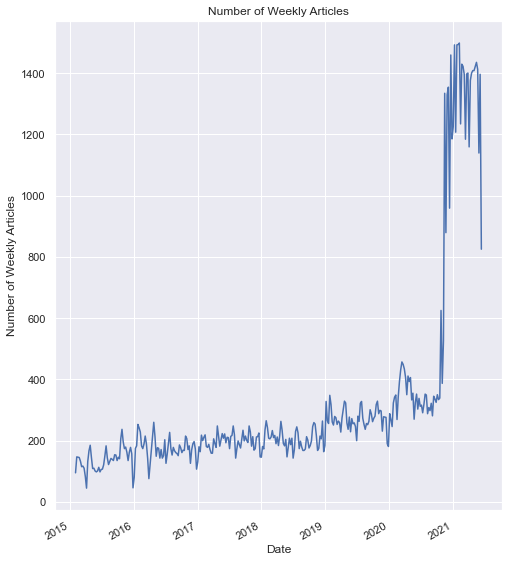

In [53]:
# dfsentimentStore['Date'] = pd.to_datetime(dfsentimentStore['Date'])

# # Drop redundant columns
# dfsentimentStore = dfsentimentStore.drop(['Unnamed: 0'], axis = 1)
sns.set()
dfsentimentStore = dfsentiment.dropna()
dfsentimentStore
dfsentimentStore['Date'].sub(pd.to_timedelta(dfsentimentStore['Date'].dt.dayofweek, unit='D')).value_counts(sort=False).iloc[:-1].plot(title='Number of Weekly Articles', ylabel='Number of Weekly Articles', xlabel='Date')
plt.savefig("Weeklyarticleevolution1.pdf", dpi=300, bbox_inches='tight') # save as pdf
#IT IS NOT REALLY THE NUMBER OF ARTICLES, BUT THE NUMBER OF SENTIMENT DATAPOINTS, 
#THIS IS BECAUSE WHEN WE HAVE 3 ARTICLES IN THE SAME DAY, THE SENTIMENT IS AVERAGED AND COUNTED AS A SINGLE SENTIMENT DATAPOINT,
#THIS IS WHY THE SUM OF ARTICLES IS LOWER THAN THE 450K WE INITIALLY HAD
#(IT IS ALSO LOWER BC WE ONLY DID 2015-2021)


107393


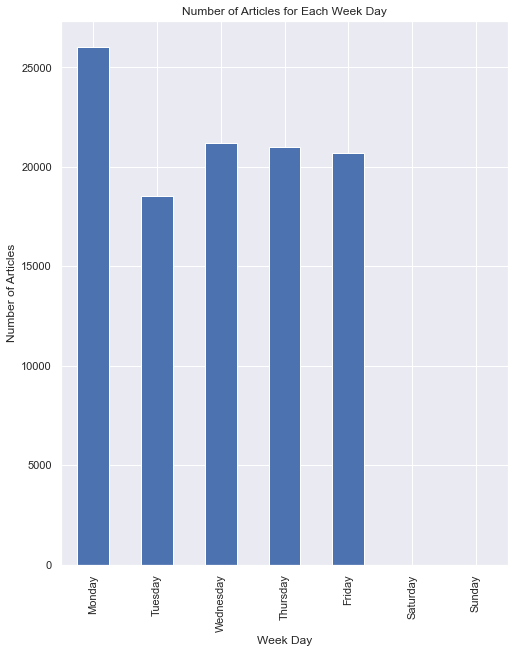

In [54]:
weekdayCount = dfsentimentStore['Date'].dt.day_name().value_counts()
print(weekdayCount.sum())
weekdayCount = weekdayCount.reindex(index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
weekdayCount.plot(title='Number of Articles for Each Week Day', ylabel='Number of Articles', xlabel='Week Day', kind='bar')
plt.savefig("Articlebyday1.pdf", dpi=300, bbox_inches='tight') # save as pdf
#THE REASON WHY THERE ARE MORE ARTICLES ON MONDAY IS THAT ALL THE ARTICLES FROM FRIDAY TO SUNDAY ARE TAKEN INTO ACCOUNT IN MONDAY'S SENTIMENT,
#SO WE HAVE MORE ARTICLES THAN FOR THE OTHER DAYS

In [55]:
print(dfreturns['Ticker'].nunique())
print(dfticker['Company'].nunique())

1451
467


In [56]:
dfsentiment.dropna()[['Date', 'Company', 'LMD_Polarity']].head(10)

,Date,Company,LMD_Polarity
2,2015-02-04,AT&T Inc,-0.541667
3,2015-02-04,AbbVie,-0.195393
21,2015-02-04,Amazon,0.473684
32,2015-02-04,Amgen,0.045455
43,2015-02-04,Archer Daniels Midland,-0.058824
49,2015-02-04,AutoNation Inc.,0.646753
60,2015-02-04,BP,-0.238095
72,2015-02-04,Biogen,0.333333
125,2015-02-04,Comcast Corporation,-0.750000
170,2015-02-04,Eaton Corporation,-0.090909


## 10% Portfolio  <a class="anchor" id="10"></a>
[ToC](#contents)

In [57]:
list_methods = ['LMD_Polarity']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1]

for x in range(0, len(list_methods)):
    for i in range(0, len(lst)):
        sample_df = dfsentiment[dfsentiment['Date'] == lst[i]]
        sample_df = sample_df.dropna(subset=[list_methods[x]])
        total_return = 0
        total_count = 0

        large_df = sample_df.nlargest(int(0.1 * len(sample_df)), list_methods[x])
        small_df = sample_df.nsmallest(int(0.1 * len(sample_df)), list_methods[x])

        total_ret_long = large_df['Return'].sum()
        count_long = len(large_df)

        total_ret_short = small_df['Return'].sum()
        count_short = len(small_df)

        if count_long > 0: 
            total_ret_long = total_ret_long / count_long 

        if count_short > 0:
            total_ret_short = total_ret_short / count_short

        total_return = 100 * (total_ret_long - total_ret_short)
        dict_ret[x][lst[i]] = total_return

In [58]:
newportfolio10 = pd.DataFrame(dict_ret).transpose()
newportfolio10 = newportfolio10.rename(columns={0: 'LMD_Polarity'})
newportfolio10.to_csv('10percentportfolio.csv')

print(newportfolio10.head())

            LMD_Polarity
2015-02-03      0.000000
2015-02-04     -0.038692
2015-02-05     -0.211616
2015-02-06      0.209519
2015-02-09     -0.086861


<AxesSubplot:title={'center':'MSTD(30) Returns of Long-Short (10%) Portfolio (All news)'}, xlabel='Date', ylabel='MSTD Returns (%)'>

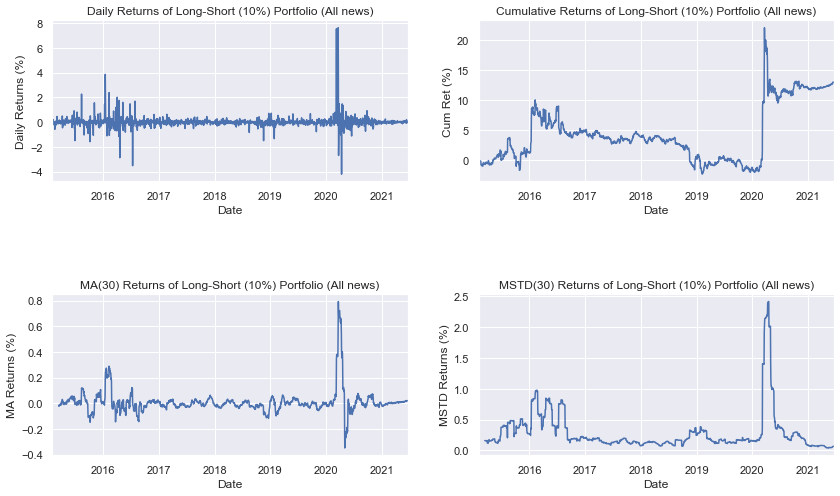

In [59]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(14,8))
plt.subplots_adjust(hspace=0.7)
#newportfolio10 = newportfolio10.set_index('Date')
#fig.set_facecolor('white')
#plt.grid(color='black', linewidth=0.1)
newportfolio10.plot(ax=ax1, title='Daily Returns of Long-Short (10%) Portfolio (All news)', xlabel='Date', ylabel='Daily Returns (%)', grid=True, legend='')
newportfolio10.cumsum().plot(ax=ax2, title='Cumulative Returns of Long-Short (10%) Portfolio (All news)', xlabel='Date', ylabel='Cum Ret (%)', grid=True, legend='')
newportfolio10.rolling(30).mean().plot(ax=ax3, title='MA(30) Returns of Long-Short (10%) Portfolio (All news)', xlabel='Date', ylabel='MA Returns (%)', grid=True, legend='')
newportfolio10.rolling(30).std().plot(ax=ax4, title='MSTD(30) Returns of Long-Short (10%) Portfolio (All news)', xlabel='Date', ylabel='MSTD Returns (%)', grid=True, legend='')

LMD_Polarity    0.281435
dtype: float64


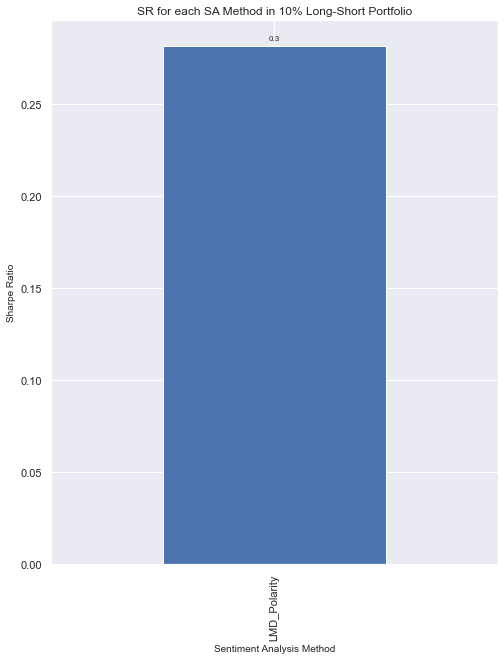

In [60]:
newportfolio10 = pd.read_csv('10percentportfolio.csv')
newportfolio10 = newportfolio10.rename(columns={'Unnamed: 0': 'Date'})
methodreturn = newportfolio10[['LMD_Polarity']]

mean_return = methodreturn.mean()
std_return = methodreturn.std()
businessDays = 252
annual_factor = np.sqrt(businessDays)
SR = (mean_return*annual_factor)/(std_return)
snr10=SR
print(SR)
plots = SR.plot.bar(title='SR for each SA Method in 10% Long-Short Portfolio')
plt.xlabel("Sentiment Analysis Method", size=10)
plt.ylabel("Sharpe Ratio", size=10)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.1f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

In [61]:
print(newportfolio10.cumsum().tail(1))
print(newportfolio10.mean())
print(newportfolio10.std())

                                                   Date  LMD_Polarity
1662  2015-02-032015-02-042015-02-052015-02-062015-0...     12.921691
LMD_Polarity    0.00777
dtype: float64
LMD_Polarity    0.438278
dtype: float64


## 20% Porfolio  <a class="anchor" id="20"></a>
[ToC](#contents)

In [62]:
list_methods = ['LMD_Polarity']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1]

for x in range(0, len(list_methods)):
    for i in range(0, len(lst)):
        sample_df = dfsentiment[dfsentiment['Date'] == lst[i]]
        sample_df = sample_df.dropna(subset=[list_methods[x]])
        total_return = 0
        total_count = 0

        large_df = sample_df.nlargest(int(0.2 * len(sample_df)), list_methods[x])
        small_df = sample_df.nsmallest(int(0.2 * len(sample_df)), list_methods[x])

        total_ret_long = large_df['Return'].sum()
        count_long = len(large_df)

        total_ret_short = small_df['Return'].sum()
        count_short = len(small_df)

        if count_long > 0: 
            total_ret_long = total_ret_long / count_long 

        if count_short > 0:
            total_ret_short = total_ret_short / count_short

        total_return = 100 * (total_ret_long - total_ret_short)
        dict_ret[x][lst[i]] = total_return

In [63]:
newportfolio20 = pd.DataFrame(dict_ret).transpose()
newportfolio20 = newportfolio20.rename(columns={0: 'LMD_Polarity'})
newportfolio20.to_csv('20percentportfolio.csv')

            LMD_Polarity
2021-06-11     -0.020001
2021-06-14      0.038640
2021-06-15      0.015354
2021-06-16     -0.008651
2021-06-17      0.000000


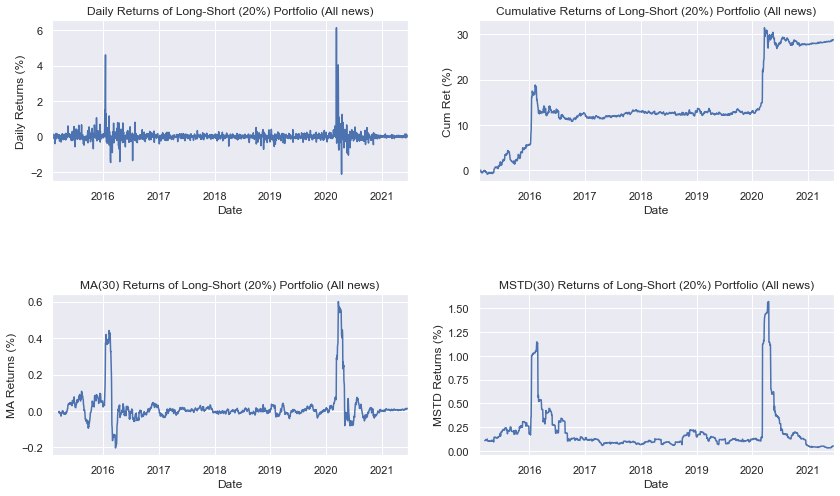

In [64]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(14,8))
plt.subplots_adjust(hspace=0.7)
#newportfolio20 = newportfolio20.set_index('Date')
newportfolio20.plot(ax=ax1, title='Daily Returns of Long-Short (20%) Portfolio (All news)', xlabel='Date', ylabel='Daily Returns (%)', grid=True, legend='')
newportfolio20.cumsum().plot(ax=ax2, title='Cumulative Returns of Long-Short (20%) Portfolio (All news)', xlabel='Date', ylabel='Cum Ret (%)', grid=True, legend='')
newportfolio20.rolling(30).mean().plot(ax=ax3, title='MA(30) Returns of Long-Short (20%) Portfolio (All news)', xlabel='Date', ylabel='MA Returns (%)', grid=True, legend='')
newportfolio20.rolling(30).std().plot(ax=ax4, title='MSTD(30) Returns of Long-Short (20%) Portfolio (All news)', xlabel='Date', ylabel='MSTD Returns (%)', grid=True, legend='')

print(newportfolio20.tail())

LMD_Polarity    0.891924
dtype: float64


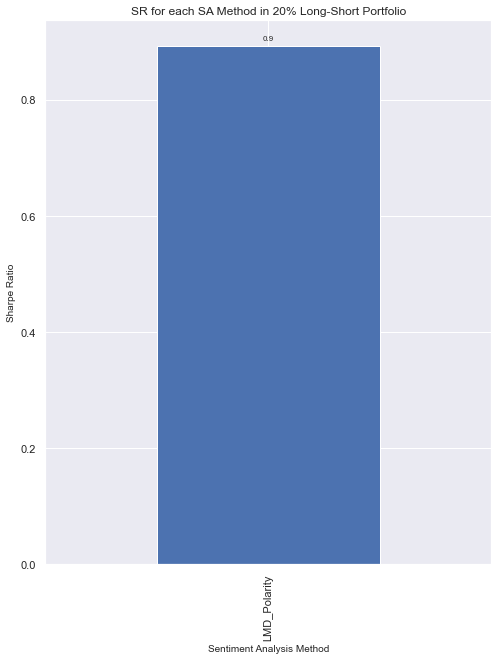

In [65]:
newportfolio20 = pd.read_csv('20percentportfolio.csv')
newportfolio20 = newportfolio20.rename(columns={'Unnamed: 0': 'Date'})
# newportfolio20 = newportfolio20[~(newportfolio20['Date'] < '2019-01-01')]
methodreturn = newportfolio20[['LMD_Polarity']]

annual_factor = np.sqrt(262)
SR = (methodreturn.mean()*annual_factor)/(methodreturn.std())
snr20=SR
print(SR)
plots = SR.plot.bar(title='SR for each SA Method in 20% Long-Short Portfolio')
plt.xlabel("Sentiment Analysis Method", size=10)
plt.ylabel("Sharpe Ratio", size=10)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.1f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

In [66]:
print(newportfolio20.mean())
print(newportfolio20.std())
newportfolio20.cumsum().tail(1)

LMD_Polarity    0.017288
dtype: float64
LMD_Polarity    0.313732
dtype: float64


,Date,LMD_Polarity
1662,2015-02-032015-02-042015-02-052015-02-062015-0...,28.74935


## 30% Porfolio  <a class="anchor" id="30"></a>
[ToC](#contents)

In [67]:
list_methods = ['LMD_Polarity']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1]

for x in range(0, len(list_methods)):
    for i in range(0, len(lst)):
        sample_df = dfsentiment[dfsentiment['Date'] == lst[i]]
        sample_df = sample_df.dropna(subset=[list_methods[x]])
        total_return = 0
        total_count = 0

        large_df = sample_df.nlargest(int(0.3 * len(sample_df)), list_methods[x])
        small_df = sample_df.nsmallest(int(0.3 * len(sample_df)), list_methods[x])

        total_ret_long = large_df['Return'].sum()
        count_long = len(large_df)

        total_ret_short = small_df['Return'].sum()
        count_short = len(small_df)

        if count_long > 0: 
            total_ret_long = total_ret_long / count_long 

        if count_short > 0:
            total_ret_short = total_ret_short / count_short

        total_return = 100 * (total_ret_long - total_ret_short)
        dict_ret[x][lst[i]] = total_return

In [68]:
newportfolio30 = pd.DataFrame(dict_ret).transpose()
newportfolio30 = newportfolio30.rename(columns={0: 'LMD_Polarity'})
newportfolio30.to_csv('30percentportfolio.csv')

            LMD_Polarity
2021-06-11     -0.024716
2021-06-14      0.052444
2021-06-15      0.033253
2021-06-16      0.001844
2021-06-17      0.000000


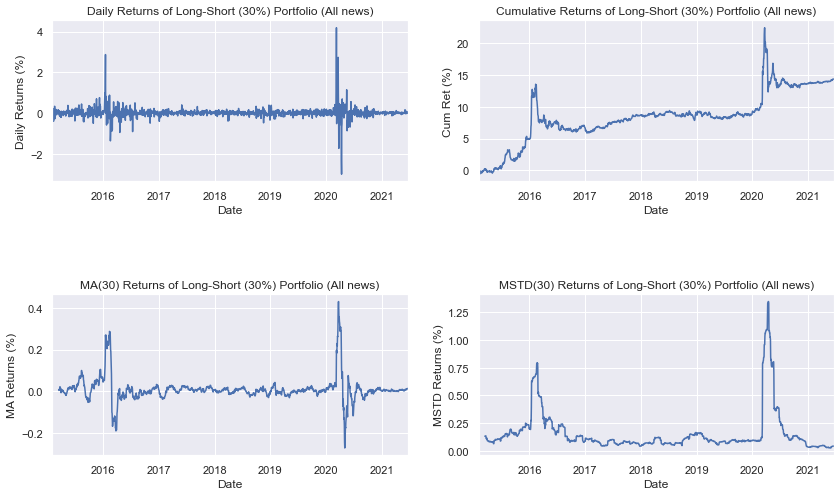

In [69]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(14,8))
plt.subplots_adjust(hspace=0.7)
#newportfolio30 = newportfolio20.set_index('Date')
newportfolio30.plot(ax=ax1, title='Daily Returns of Long-Short (30%) Portfolio (All news)', xlabel='Date', ylabel='Daily Returns (%)', grid=True, legend='')
newportfolio30.cumsum().plot(ax=ax2, title='Cumulative Returns of Long-Short (30%) Portfolio (All news)', xlabel='Date', ylabel='Cum Ret (%)', grid=True, legend='')
newportfolio30.rolling(30).mean().plot(ax=ax3, title='MA(30) Returns of Long-Short (30%) Portfolio (All news)', xlabel='Date', ylabel='MA Returns (%)', grid=True, legend='')
newportfolio30.rolling(30).std().plot(ax=ax4, title='MSTD(30) Returns of Long-Short (30%) Portfolio (All news)', xlabel='Date', ylabel='MSTD Returns (%)', grid=True, legend='')

print(newportfolio30.tail())

LMD_Polarity    0.567104
dtype: float64


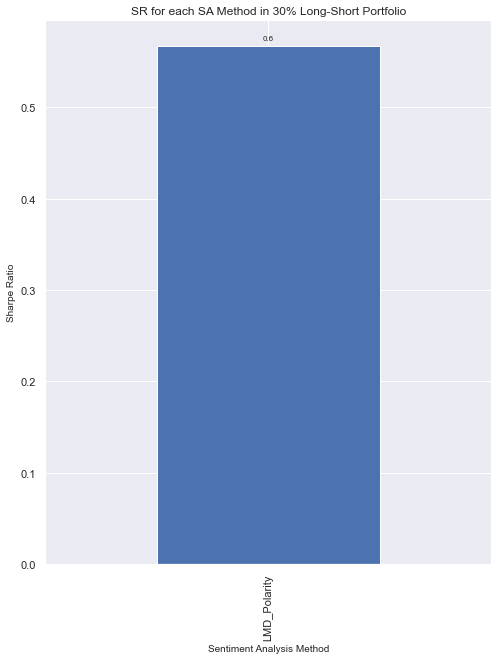

In [70]:
newportfolio30 = pd.read_csv('30percentportfolio.csv')
newportfolio30 = newportfolio30.rename(columns={'Unnamed: 0': 'Date'})
# newportfolio30 = newportfolio30[~(newportfolio30['Date'] < '2019-01-01')]
methodreturn = newportfolio30[['LMD_Polarity']]

annual_factor = np.sqrt(262)
SR = (methodreturn.mean()*annual_factor)/(methodreturn.std())
snr30=SR
print(SR)
plots = SR.plot.bar(title='SR for each SA Method in 30% Long-Short Portfolio')
plt.xlabel("Sentiment Analysis Method", size=10)
plt.ylabel("Sharpe Ratio", size=10)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.1f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

## 40% Porfolio  <a class="anchor" id="40"></a>
[ToC](#contents)

In [71]:
list_methods = ['LMD_Polarity']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1]

for x in range(0, len(list_methods)):
    for i in range(0, len(lst)):
        sample_df = dfsentiment[dfsentiment['Date'] == lst[i]]
        sample_df = sample_df.dropna(subset=[list_methods[x]])
        total_return = 0
        total_count = 0

        large_df = sample_df.nlargest(int(0.4 * len(sample_df)), list_methods[x])
        small_df = sample_df.nsmallest(int(0.4 * len(sample_df)), list_methods[x])

        total_ret_long = large_df['Return'].sum()
        count_long = len(large_df)

        total_ret_short = small_df['Return'].sum()
        count_short = len(small_df)

        if count_long > 0: 
            total_ret_long = total_ret_long / count_long 

        if count_short > 0:
            total_ret_short = total_ret_short / count_short

        total_return = 100 * (total_ret_long - total_ret_short)
        dict_ret[x][lst[i]] = total_return

In [72]:
newportfolio40 = pd.DataFrame(dict_ret).transpose()
newportfolio40 = newportfolio40.rename(columns={0: 'LMD_Polarity'})
newportfolio40.to_csv('40percentportfolio.csv')

            LMD_Polarity
2021-06-11     -0.009573
2021-06-14      0.034850
2021-06-15      0.043157
2021-06-16     -0.009605
2021-06-17      0.000000


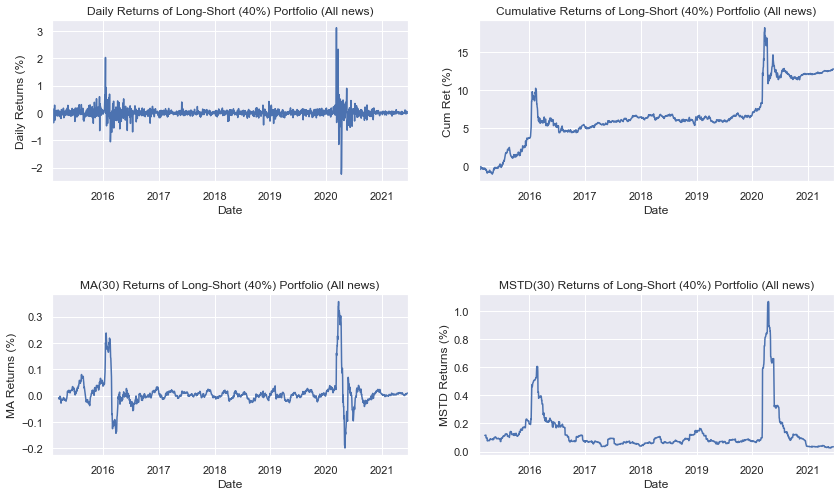

In [73]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(14,8))
plt.subplots_adjust(hspace=0.7)
#newportfolio40 = newportfolio40.set_index('Date')
newportfolio40.plot(ax=ax1, title='Daily Returns of Long-Short (40%) Portfolio (All news)', xlabel='Date', ylabel='Daily Returns (%)', grid=True, legend='')
newportfolio40.cumsum().plot(ax=ax2, title='Cumulative Returns of Long-Short (40%) Portfolio (All news)', xlabel='Date', ylabel='Cum Ret (%)', grid=True, legend='')
newportfolio40.rolling(30).mean().plot(ax=ax3, title='MA(30) Returns of Long-Short (40%) Portfolio (All news)', xlabel='Date', ylabel='MA Returns (%)', grid=True, legend='')
newportfolio40.rolling(30).std().plot(ax=ax4, title='MSTD(30) Returns of Long-Short (40%) Portfolio (All news)', xlabel='Date', ylabel='MSTD Returns (%)', grid=True, legend='')

print(newportfolio40.tail())

LMD_Polarity    0.625273
dtype: float64


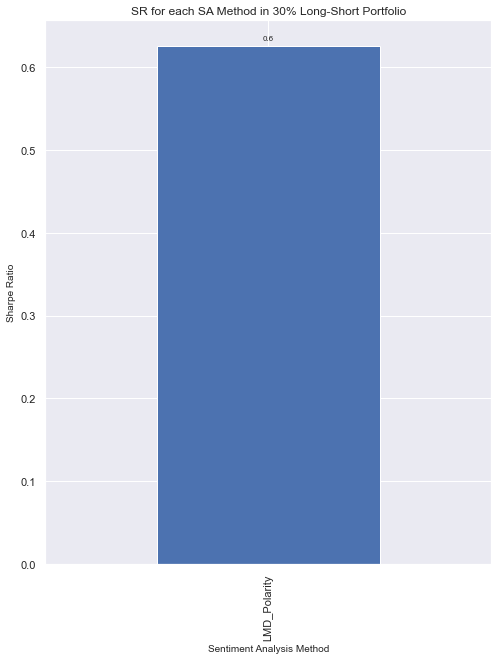

In [74]:
newportfolio40 = pd.read_csv('40percentportfolio.csv')
newportfolio40 = newportfolio40.rename(columns={'Unnamed: 0': 'Date'})
# newportfolio40 = newportfolio40[~(newportfolio30['Date'] < '2019-01-01')]
methodreturn = newportfolio40[['LMD_Polarity']]

annual_factor = np.sqrt(262)
SR = (methodreturn.mean()*annual_factor)/(methodreturn.std())
snr40=SR
print(SR)
plots = SR.plot.bar(title='SR for each SA Method in 30% Long-Short Portfolio')
plt.xlabel("Sentiment Analysis Method", size=10)
plt.ylabel("Sharpe Ratio", size=10)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.1f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

## 50% Portfolio  <a class="anchor" id="50"></a>
[ToC](#contents)

In [75]:
list_methods = ['LMD_Polarity']
dict_ret1 = {}
dict_ret2 = {}
dict_ret3 = {}
dict_ret4 = {}
dict_ret5 = {}
dict_ret = [dict_ret1]

for x in range(0, len(list_methods)):
    for i in range(0, len(lst)):
        sample_df = dfsentiment[dfsentiment['Date'] == lst[i]]
        sample_df = sample_df.dropna(subset=[list_methods[x]])
        total_return = 0
        total_count = 0

        large_df = sample_df.nlargest(int(0.5 * len(sample_df)), list_methods[x])
        small_df = sample_df.nsmallest(int(0.5 * len(sample_df)), list_methods[x])

        total_ret_long = large_df['Return'].sum()
        count_long = len(large_df)

        total_ret_short = small_df['Return'].sum()
        count_short = len(small_df)

        if count_long > 0: 
            total_ret_long = total_ret_long / count_long 

        if count_short > 0:
            total_ret_short = total_ret_short / count_short

        total_return = 100 * (total_ret_long - total_ret_short)
        dict_ret[x][lst[i]] = total_return

In [76]:
newportfolio50 = pd.DataFrame(dict_ret).transpose()
newportfolio50 = newportfolio50.rename(columns={0: 'LMD_Polarity'})
newportfolio50.to_csv('50percentportfolio.csv')

            LMD_Polarity
2015-02-03      0.000000
2015-02-04      0.074094
2015-02-05     -0.040262
2015-02-06     -0.118866
2015-02-09      0.058584


<AxesSubplot:title={'center':'MSTD(30) Returns of Long-Short (50%) Portfolio (All news)'}, xlabel='Date', ylabel='MSTD Returns (%)'>

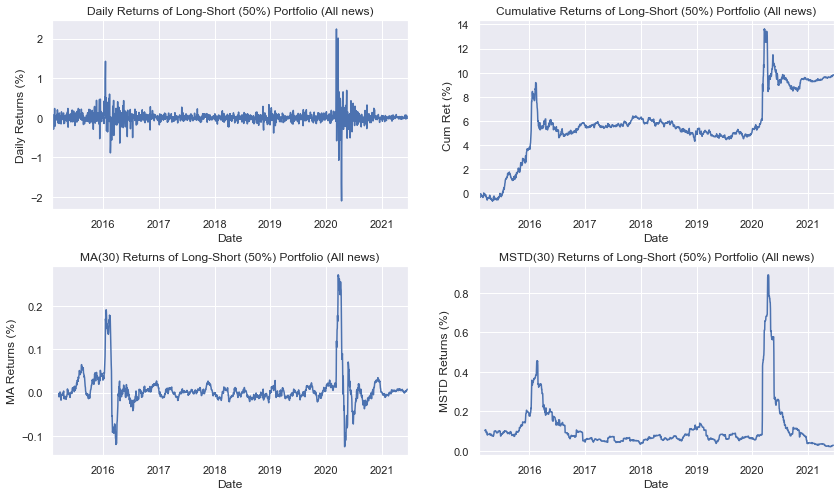

In [77]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(14,8))
plt.subplots_adjust(hspace=0.3)
print(newportfolio50.head())
newportfolio50.plot(ax=ax1, title='Daily Returns of Long-Short (50%) Portfolio (All news)', xlabel='Date', ylabel='Daily Returns (%)', grid=True, legend='')
newportfolio50.cumsum().plot(ax=ax2, title='Cumulative Returns of Long-Short (50%) Portfolio (All news)', xlabel='Date', ylabel='Cum Ret (%)', grid=True, legend='')
newportfolio50.rolling(30).mean().plot(ax=ax3, title='MA(30) Returns of Long-Short (50%) Portfolio (All news)', xlabel='Date', ylabel='MA Returns (%)', grid=True, legend='')
newportfolio50.rolling(30).std().plot(ax=ax4, title='MSTD(30) Returns of Long-Short (50%) Portfolio (All news)', xlabel='Date', ylabel='MSTD Returns (%)', grid=True, legend='')

LMD_Polarity    0.574919
dtype: float64


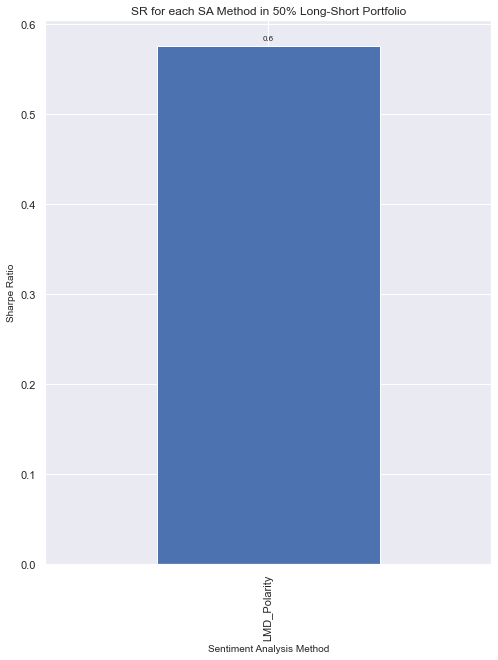

In [78]:
newportfolio50 = pd.read_csv('50percentportfolio.csv')
newportfolio50 = newportfolio50.rename(columns={'Unnamed: 0': 'Date'})
methodreturn = newportfolio50[['LMD_Polarity']]

annual_factor = np.sqrt(262)
SR = (methodreturn.mean()*annual_factor)/(methodreturn.std())
snr50=SR
print(SR)
plots = SR.plot.bar(title='SR for each SA Method in 50% Long-Short Portfolio')
plt.xlabel("Sentiment Analysis Method", size=10)
plt.ylabel("Sharpe Ratio", size=10)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.1f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

         Date  LMD_Polarity
0  2015-02-03      0.000000
1  2015-02-04      0.074094
2  2015-02-05     -0.040262
3  2015-02-06     -0.118866
4  2015-02-09      0.058584
         Date  LMD_Polarity
0  2015-02-03      0.000000
1  2015-02-04      0.037059
2  2015-02-05     -0.088565
3  2015-02-06     -0.015974
4  2015-02-09     -0.088069
         Date  LMD_Polarity
0  2015-02-03      0.000000
1  2015-02-04     -0.038692
2  2015-02-05     -0.211616
3  2015-02-06      0.209519
4  2015-02-09     -0.086861


<AxesSubplot:title={'center':'50% Portfolio (All news)'}, xlabel='Date', ylabel='Cum Ret (%)'>

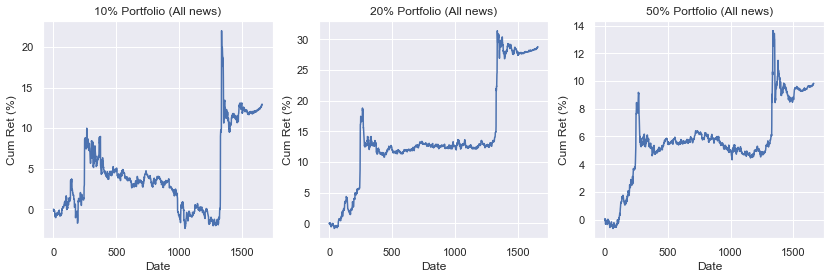

In [79]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14,4))
plt.subplots_adjust(hspace=0.3)
print(newportfolio50.head())
print(newportfolio20.head())
print(newportfolio10.head())
newportfolio10.cumsum().plot(ax=ax1, title='10% Portfolio (All news)', xlabel='Date', ylabel='Cum Ret (%)', grid=True, legend='')
newportfolio20.cumsum().plot(ax=ax2, title='20% Portfolio (All news)', xlabel='Date', ylabel='Cum Ret (%)', grid=True, legend='')
newportfolio50.cumsum().plot(ax=ax3, title='50% Portfolio (All news)', xlabel='Date', ylabel='Cum Ret (%)', grid=True, legend='')


         Date       10%
0  2015-02-03  0.000000
1  2015-02-04 -0.038692
2  2015-02-05 -0.211616
3  2015-02-06  0.209519
4  2015-02-09 -0.086861
         Date       10%       20%       30%       40%       50%
0  2015-02-03  0.000000  0.000000  0.000000  0.000000  0.000000
1  2015-02-04 -0.038692  0.037059 -0.022323  0.027426  0.074094
2  2015-02-05 -0.211616 -0.088565 -0.061796 -0.007442 -0.040262
3  2015-02-06  0.209519 -0.015974 -0.084039 -0.092070 -0.118866
4  2015-02-09 -0.086861 -0.088069 -0.055269 -0.018441  0.058584


<Figure size 576x432 with 0 Axes>

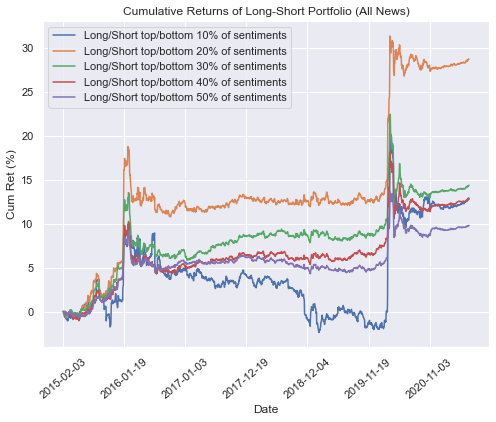

In [84]:
Total_df=newportfolio10.copy()
Total_df.rename(columns={"LMD_Polarity":"10%"}, inplace=True)
print(Total_df.head())
Total_df['20%']=newportfolio20['LMD_Polarity']
Total_df['30%']=newportfolio30['LMD_Polarity']
Total_df['40%']=newportfolio40['LMD_Polarity']
Total_df['50%']=newportfolio50['LMD_Polarity']
print(Total_df.head())
plt.figure()
Total_df_final = Total_df.set_index('Date')
Total_df_final.cumsum().plot()

plt.xticks(rotation=40)
plt.title('Cumulative Returns of Long-Short Portfolio (All News)')
plt.xlabel('Date')
plt.ylabel('Cum Ret (%)')
plt.grid(True)
plt.legend(['Long/Short top/bottom 10% of sentiments', 'Long/Short top/bottom 20% of sentiments', 'Long/Short top/bottom 30% of sentiments', 'Long/Short top/bottom 40% of sentiments', 'Long/Short top/bottom 50% of sentiments'])
plt.rcParams["figure.figsize"] = (8, 10)
plt.savefig("portfolio1.pdf", dpi=300, bbox_inches='tight') # save as pdf

In [81]:
print(snr10)
print(snr20)
print(snr30)
print(snr40)
print(snr50)

LMD_Polarity    0.281435
dtype: float64
LMD_Polarity    0.891924
dtype: float64
LMD_Polarity    0.567104
dtype: float64
LMD_Polarity    0.625273
dtype: float64
LMD_Polarity    0.574919
dtype: float64
